In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import random
import os
import argparse
from sklearn.metrics import precision_recall_curve

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

dnase_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/bqtls_pu1_preds/snp_scores.tsv"
atac_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/bqtls_pu1_preds/snp_scores.tsv"
#atac_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/subsampling/GM12878_250M/bqtls_pu1_preds/snp_scores.tsv"


In [2]:
bqtls_dnase = pd.read_csv(dnase_preds,sep="\t", header=0, index_col=False)
bqtls_dnase[['Depth', 'ALTdepth', 'REFDepth', 'POSTfreq', 'prechipfreq', 'pvalue']] = bqtls_dnase['META_DATA'].str.split(",", expand=True)

bqtls_atac = pd.read_csv(atac_preds,sep="\t", header=0, index_col=False)
bqtls_atac[['Depth', 'ALTdepth', 'REFDepth', 'POSTfreq', 'prechipfreq', 'pvalue']] = bqtls_atac['META_DATA'].str.split(",", expand=True)



In [3]:
bqtls_atac.shape

(999799, 14)

In [4]:
bqtls_dnase.shape

(999799, 14)

In [5]:
bqtls_dnase['pvalue'] = bqtls_dnase['pvalue'].astype(float)

high_sig_index=bqtls_dnase.nsmallest(100,'pvalue').index
non_sig=bqtls_dnase.nlargest(1000,'pvalue')
non_sig_index = non_sig.sample(100).index


snps_dnase=pd.concat((bqtls_dnase.loc[high_sig_index,:],bqtls_dnase.loc[non_sig_index,:]),axis=0)
snps_dnase["sig"] = [True]*100+[False]*100
snps_dnase['color']='r'
snps_dnase['color'][snps_dnase['sig']==True]='b'

snps_dnase['logratio']=np.log2((snps_dnase['prechipfreq'].astype(float)+.01)/(snps_dnase['POSTfreq'].astype(float)+0.01))


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [6]:
snps_atac=pd.concat((bqtls_atac.loc[high_sig_index,:],bqtls_atac.loc[non_sig_index,:]),axis=0)
snps_atac["sig"] = [True]*100+[False]*100
snps_atac['color']='r'
snps_atac['color'][snps_atac['sig']==True]='b'
snps_atac['logratio']=np.log2((snps_atac['prechipfreq'].astype(float)+.01)/(snps_atac['POSTfreq'].astype(float)+0.01))


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
from plotnine import * 


In [8]:
snps_atac.head()


,CHR,POS0,REF,ALT,META_DATA,log_counts_diff,log_probs_diff_abs_sum,probs_jsd_diff,Depth,ALTdepth,REFDepth,POSTfreq,prechipfreq,pvalue,sig,color,logratio
8,chr15,70174408,C,T,"264,226,38,0.143939393939394,0.775476361534322...",1.209530,423.35458,0.162867,264,226,38,0.143939393939394,0.775476361534322,0.0,True,b,2.351205
9,chr12,8608501,T,A,"443,16,427,0.963882618510158,0.502999394689219...",0.136118,45.98726,0.018784,443,16,427,0.963882618510158,0.502999394689219,0.0,True,b,-0.924791
10,chr5,124341258,T,A,"433,406,27,0.0623556581986143,0.53645155999153...",0.420469,291.99700,0.138230,433,406,27,0.0623556581986143,0.536451559991531,0.0,True,b,2.916916
11,chr7,31728179,T,C,"533,6,527,0.98874296435272,0.552467614234308,0.0",-0.985941,-213.97040,-0.088698,533,6,527,0.98874296435272,0.552467614234308,0.0,True,b,-0.828343
12,chr4,116877280,G,C,"518,18,500,0.965250965250965,0.543736393143021...",-0.504433,-313.09637,-0.149548,518,18,500,0.965250965250965,0.543736393143021,0.0,True,b,-0.816574


In [9]:
p = (ggplot(snps_atac, aes('logratio', 'probs_jsd_diff', color='factor(sig)'))
 + geom_point(alpha=1,size=1)
 + geom_smooth(method = "lm", se = False, color="black", size=0.2)
 + xlab("Observed")
 + ylab("Predicted")
 + scale_color_manual(values=['#e41a1c','#377eb8'],name="Significant bQTL?")
 + theme_classic() 
)
p.save("subfigs/bqtls_atac_significant_hits.pdf",dpi="300")

/users/anusri/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/anusri/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: subfigs/bqtls_atac_significant_hits.pdf


In [10]:
import scipy


In [11]:
scipy.stats.pearsonr(snps_atac['logratio'],snps_atac['probs_jsd_diff'])

(0.6941713438667948, 4.349137284895023e-30)

In [12]:
scipy.stats.spearmanr(snps_atac['logratio'],snps_atac['probs_jsd_diff'])

SpearmanrResult(correlation=0.6605640141003526, pvalue=1.90862053572891e-26)

In [13]:
scipy.stats.pearsonr(snps_dnase['logratio'],snps_dnase['probs_jsd_diff'])

(0.7170608646280568, 7.192291112957865e-33)

In [14]:
bqtls_atac['logratio']=np.log2((bqtls_atac['prechipfreq'].astype(float)+.01)/(bqtls_atac['POSTfreq'].astype(float)+0.01))


In [15]:
scipy.stats.wilcoxon(bqtls_atac["probs_jsd_diff"],bqtls_atac["logratio"])


WilcoxonResult(statistic=221449852835.0, pvalue=0.0)

In [16]:
bqtls_dnase['logratio']=np.log2((bqtls_dnase['prechipfreq'].astype(float)+.01)/(bqtls_dnase['POSTfreq'].astype(float)+0.01))

scipy.stats.wilcoxon(bqtls_dnase["probs_jsd_diff"],bqtls_dnase["logratio"])


WilcoxonResult(statistic=221823985398.0, pvalue=0.0)

In [17]:
bqtls_atac["label"] = bqtls_atac["pvalue"].astype(float)<5e-8

bqtls_dnase["label"] = bqtls_dnase["pvalue"].astype(float)<5e-8


In [18]:
scipy.stats.wilcoxon(abs(bqtls_dnase["probs_jsd_diff"]),bqtls_dnase["label"])


WilcoxonResult(statistic=959336160.0, pvalue=0.0)

999799 960


Text(0, 0.5, 'Precision')

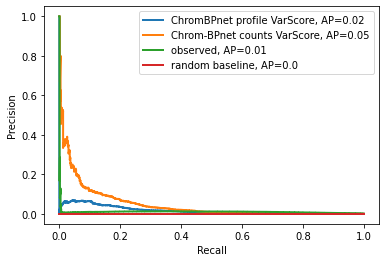

In [19]:
dsqtl=bqtls_dnase

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(dsqtl["label"], abs(dsqtl["log_probs_diff_abs_sum"]))
roc_auc = metrics.average_precision_score(dsqtl["label"], abs(dsqtl["log_probs_diff_abs_sum"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet profile VarScore, AP="+str(round(roc_auc,2)))

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(dsqtl["label"], abs(dsqtl["log_counts_diff"]))
roc_auc = metrics.average_precision_score(dsqtl["label"], abs(dsqtl["log_counts_diff"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="Chrom-BPnet counts VarScore, AP="+str(round(roc_auc,2)))

fpr_gkm, tpr_gkm, _ = precision_recall_curve(dsqtl["label"],abs(dsqtl["logratio"]))
roc_auc = metrics.average_precision_score(dsqtl["label"], abs(dsqtl["logratio"]))
plt.plot(tpr_gkm, fpr_gkm, linewidth=2, label="observed, AP="+str(round(roc_auc,2)))

in1 = list(dsqtl["label"])
random.shuffle(in1)
in1=np.array(in1)

fpr_random, tpr_random, _ = precision_recall_curve(dsqtl["label"], in1)
roc_auc = metrics.average_precision_score(dsqtl["label"], in1)
plt.plot(tpr_random, [sum(dsqtl["label"]==1)/len(dsqtl["label"])]*len(fpr_random), linewidth=2, label="random baseline, AP="+str(round(roc_auc,2)))

print(len(dsqtl["label"]), sum(dsqtl["label"]==1))
plt.legend(loc='upper right')
plt.xlabel("Recall")
plt.ylabel("Precision")

#plt.savefig("pr_curve_atac_dsqtls_gm.pdf")



In [20]:
 #plt.hist(bqtls_atac["pvalue"])

In [21]:
np.max(bqtls_atac["pvalue"].astype(np.float64))

1.0

In [22]:
bins = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 5e-6, 7e-6, 8e-6, 9e-6, 10e-6, 1]

digitized = np.digitize(bqtls_atac["pvalue"].astype(np.float64), bins)
bin_means = [np.mean(np.abs(np.array(bqtls_atac["log_probs_diff_abs_sum"]))[digitized == i]) for i in range(0, len(bins)-1)]
print(bins)

[1e-06, 2e-06, 3e-06, 4e-06, 5e-06, 5e-06, 7e-06, 8e-06, 9e-06, 1e-05, 1]


/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars


/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce


<ErrorbarContainer object of 3 artists>

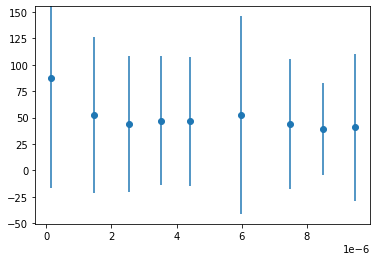

In [23]:
pval_means = [np.mean(bqtls_atac["pvalue"].astype(np.float64)[digitized == i]) for i in range(0, len(bins)-1)]
bin_std = [np.std(np.abs(np.array(bqtls_atac["log_probs_diff_abs_sum"]))[digitized == i]) for i in range(0, len(bins)-1)]
plt.errorbar(pval_means, bin_means, yerr=bin_std, fmt='o')


In [24]:
bins = np.arange(0, 1e-5, 10)


In [25]:
bqtls_atac

,CHR,POS0,REF,ALT,META_DATA,log_counts_diff,log_probs_diff_abs_sum,probs_jsd_diff,Depth,ALTdepth,REFDepth,POSTfreq,prechipfreq,pvalue,logratio,label
0,chr17,18967175,A,G,"538,418,120,0.223048327137546,0.86669872611129...",0.136641,92.031660,0.048009,538,418,120,0.223048327137546,0.866698726111294,2.33185325022481e-251,1.911452,True
1,chr4,176935912,C,A,"626,597,29,0.0463258785942492,0.54394889615233...",0.818362,566.367250,0.214546,626,597,29,0.0463258785942492,0.543948896152333,4.44964286369012e-162,3.297883,True
2,chr1,144534082,C,T,"618,368,250,0.40453074433657,0.057294963055923...",-0.051241,-64.966080,-0.030030,618,368,250,0.40453074433657,0.057294963055923,5.86306511316874e-141,-2.622909,True
3,chr17,19015380,T,A,"144,143,1,0.0069444444444444,0.87284967970842,...",-0.009036,-11.302584,-0.005146,144,143,1,0.0069444444444444,0.87284967970842,1.04024977748099e-126,5.703284,True
4,chr1,17231723,A,G,"2477,1321,1156,0.466693580944691,0.25519490670...",0.097229,22.168715,0.009661,2477,1321,1156,0.466693580944691,0.255194906706241,9.915947779278119e-114,-0.846009,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999794,chr7,72298788,C,T,"214,4,210,0.981308411214953,0.979511969595166,1.0",-0.049607,-45.878242,-0.026703,214,4,210,0.981308411214953,0.979511969595166,1.0,-0.002617,False
999795,chr18,46347287,A,G,"109,3,106,0.972477064220184,0.972420838814261,1.0",0.020571,11.059257,0.006015,109,3,106,0.972477064220184,0.972420838814261,1.0,-0.000083,False
999796,chr18,55508742,A,G,"65,2,63,0.969230769230769,0.975831745803566,1.0",-0.007517,-21.021800,-0.011692,65,2,63,0.969230769230769,0.975831745803566,1.0,0.009693,False
999797,chr19,16245696,A,G,"109,3,106,0.972477064220184,0.976196339907924,1.0",0.025445,32.208073,0.017349,109,3,106,0.972477064220184,0.976196339907924,1.0,0.005451,False


In [81]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 


['n: 191', 'n: 196', 'n: 408', 'n: 1374', 'n: 9765', 'n: 139245', 'n: 200408', 'n: 319347', 'n: 328619']


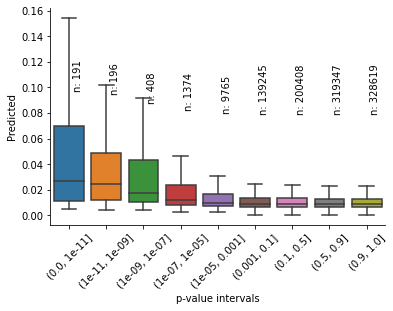

In [85]:
bins = np.array(np.arange(0,5e-9,5e-8).tolist() + [1e-2,0.1,1.0])
bins = [0,1e-11,1e-9, 1e-7, 1e-5,1e-3,1e-1,0.5,0.9,1.0 ]
bqtls_atac['value_group'] = pd.cut(bqtls_atac["pvalue"].astype(np.float64), bins=bins)
bqtls_atac['abs_log_probs_diff_abs_sum'] = np.abs(bqtls_atac['probs_jsd_diff'])
ax = sns.boxplot(x="value_group", y="abs_log_probs_diff_abs_sum", data=bqtls_atac, showfliers=False)
plt.xticks(rotation=45)
medians = bqtls_atac.groupby(['value_group'])['abs_log_probs_diff_abs_sum'].median().values
nobs= bqtls_atac['value_group'].value_counts().values[::-1]
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
print(nobs)
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(tick+0.1,medians[tick]+0.07,nobs[tick],color='black', verticalalignment = "bottom",rotation=90)
sns.despine()
ax.set(xlabel='p-value intervals', ylabel='Predicted')

plt.savefig("subfigs/bqtls_with_pval_predicted.pdf", transparent=True, dpi=300)


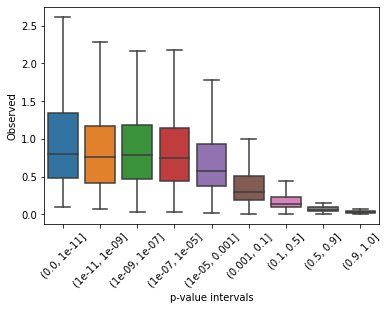

In [86]:
bins = np.array(np.arange(0,5e-9,5e-8).tolist() + [1e-2,0.1,1.0])
bins = [0,1e-11,1e-9, 1e-7, 1e-5,1e-3,1e-1,0.5,0.9,1.0 ]
bqtls_atac['value_group'] = pd.cut(bqtls_atac["pvalue"].astype(np.float64), bins=bins)
bqtls_atac['abs_log_probs_diff_abs_sum'] = np.abs(bqtls_atac['abs_logratio'])
ax = sns.boxplot(x="value_group", y="abs_log_probs_diff_abs_sum", data=bqtls_atac, showfliers=False)
plt.xticks(rotation=45)
ax.set(xlabel='p-value intervals', ylabel='Observed')

plt.savefig("subfigs/bqtls_with_pval_observed.pdf", transparent=True, dpi=300)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '(0, 1]'),
  Text(1, 0, '(1, 2]'),
  Text(2, 0, '(2, 3]'),
  Text(3, 0, '(3, 4]'),
  Text(4, 0, '(4, 5]'),
  Text(5, 0, '(5, 6]')])

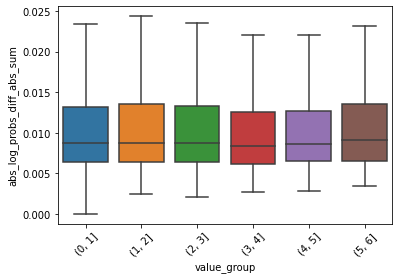

In [48]:
bins = np.array(np.arange(0,5e-9,5e-8).tolist() + [1e-2,0.1,1.0])
bins = [0,1,2,3,4,5,6]
bqtls_atac["abs_logratio"] = np.abs(bqtls_atac["logratio"].astype(np.float64))
bqtls_atac['value_group'] = pd.cut(bqtls_atac["abs_logratio"].astype(np.float64), bins=bins)
bqtls_atac['abs_log_probs_diff_abs_sum'] = np.abs(bqtls_atac['probs_jsd_diff'])
ax = sns.boxplot(x="value_group", y="abs_log_probs_diff_abs_sum", data=bqtls_atac, showfliers=False)
plt.xticks(rotation=45)


In [46]:
np.max(bqtls_atac["abs_logratio"])

5.986749586517562

In [68]:
bqtls_atac.groupby(['value_group'])['abs_log_probs_diff_abs_sum']

In [75]:
bqtls_atac['value_group'].value_counts()

(0.1, 0.5]        328619
(0.5, 0.9]        319347
(0.9, 1.0]        200408
(0.001, 0.1]      139245
(1e-05, 0.001]      9765
(1e-07, 1e-05]      1374
(1e-09, 1e-07]       408
(1e-11, 1e-09]       196
(0.0, 1e-11]         191
Name: value_group, dtype: int64